## 1. 파일 불러오기


In [149]:
# 마에스트로 노트북 파일불러오기
import pandas as pd
avocado=pd.read_csv("C:/Users/CPB02GameN/Desktop/avocado project/파이썬활용발표 포함avocado project 2(0626~)/avocadofinalchange.csv",index_col = "Unnamed: 0")

In [ ]:
# 집노트북으로 파일 불러오기
avocado=pd.read_csv("C:/Users/사용자/Desktop/과제/마에스트로 과제/avocado project/최종수정데이터/avocado1.csv",index_col = "Unnamed: 0")

In [150]:
avocado.shape

(24657, 15)

In [151]:
# Date 변수를 datetime 타입으로 변환
avocado['Date'] = pd.to_datetime(avocado['Date'])
avocado.sort_values('Date',ignore_index = True,inplace = True)
avocado['Date'].isnull().value_counts()

False    24657
Name: Date, dtype: int64

In [152]:
avocado['Day']=avocado['Date'].apply(lambda x:x.day)

In [153]:
avocado.shape

(24657, 16)

In [8]:
#avocado= pd.get_dummies(avocado)

## 2. 훈련데이터와 테스트데이터로 나누기

- 2015~2018 data로 traindata, testdata 나누기
- 2015~2018 자료로 모델을 만들고 가격 예측해보기(매개변수도 조절)
- 마지막에 2019~ 자료를 제일 적합한 모델을 가지고 예측해보고 확인하기


### 2015~2018 데이터 뽑기

In [154]:
avo1 = avocado[avocado['Date'] < '2019-01-01']
X = avo1.drop(['Date','AveragePrice','region'],axis=1)
X = pd.get_dummies(X)
y = avo1['AveragePrice']

In [155]:
avo1.columns

Index(['Date', 'AveragePrice', 'Total Volume', '4046', '4225', '4770',
       'Total Bags', 'Small Bags', 'Large Bags', 'XLarge Bags', 'type', 'year',
       'region', 'month', 'season', 'Day'],
      dtype='object')

In [156]:
X.columns

Index(['Total Volume', '4046', '4225', '4770', 'Total Bags', 'Small Bags',
       'Large Bags', 'XLarge Bags', 'year', 'month', 'Day',
       'type_conventional', 'type_organic', 'season_fall', 'season_spring',
       'season_summer', 'season_winter'],
      dtype='object')

### 연속형 특성들 히스토그램 확인하기

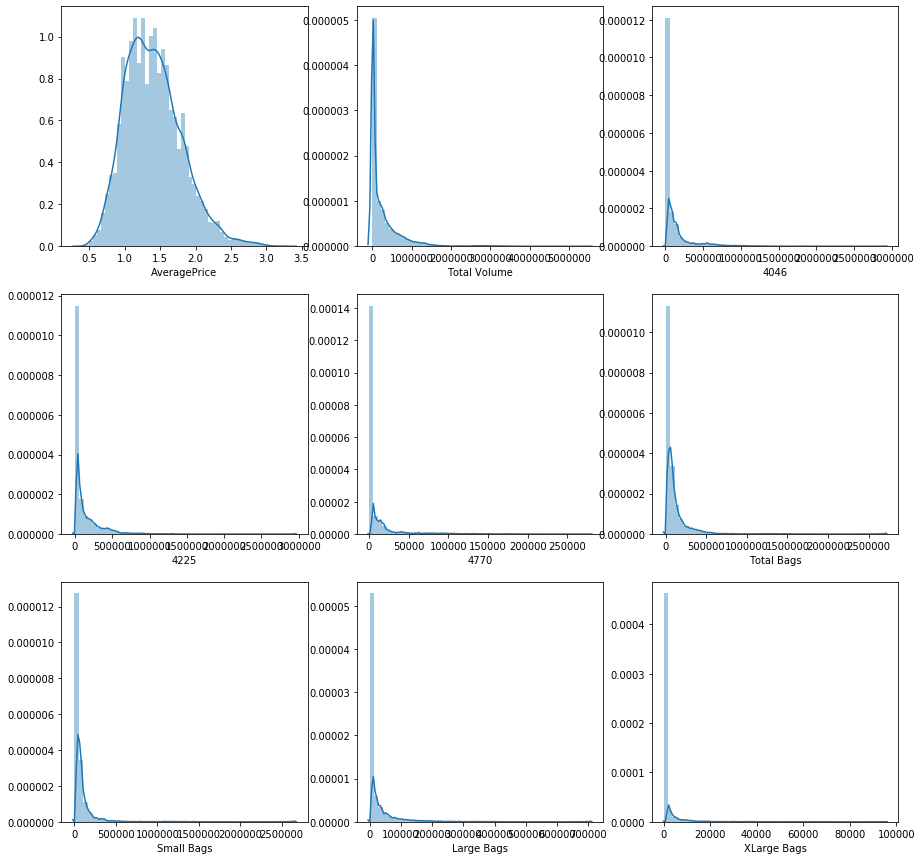

In [157]:
names =['AveragePrice', 'Total Volume', '4046', '4225', '4770',
       'Total Bags', 'Small Bags', 'Large Bags', 'XLarge Bags']

import matplotlib.pyplot as plt
import seaborn as sns
fig, axes = plt.subplots(3,3)
fig.set_size_inches(15,15)
axes = axes.ravel()

for names,i in zip(names,range(9)):
    sns.distplot(avo1[names],ax=axes[i])

### 연속형 특성에 log 씌우기

In [158]:
import numpy as np
X_names = ['Total Volume', '4046', '4225', '4770',
       'Total Bags', 'Small Bags', 'Large Bags', 'XLarge Bags']
# X 값 log 씌우기
for names in X_names:
    X[names] = np.log1p(X[names])
# Y 값 log 씌우기
y = np.log1p(y)

### log data 히스토그램 확인하기

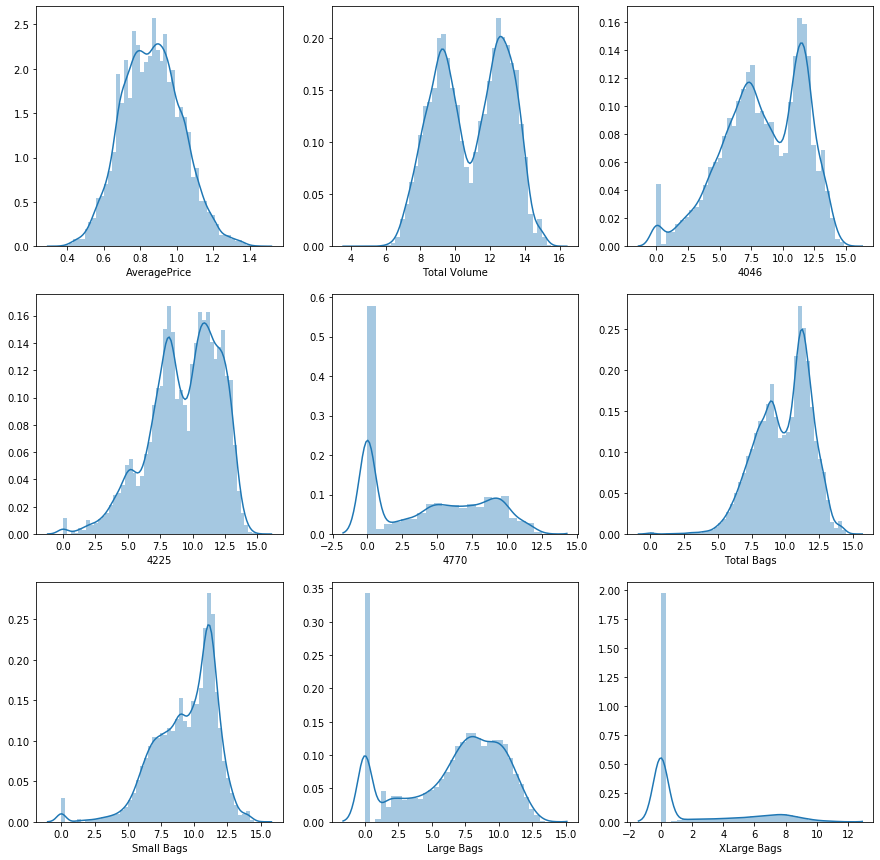

In [159]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, axes = plt.subplots(3,3)
fig.set_size_inches(15,15)
axes = axes.ravel()

for names,i in zip(X_names,range(8)):
    sns.distplot(X[names],ax=axes[i+1])

sns.distplot(y,ax=axes[0])

In [160]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=1,test_size = 0.2)

In [161]:
print("X_train의 shape:",X_train.shape,"\nX_test의 shape: ",X_test.shape)

X_train의 shape: (14829, 17) 
X_test의 shape:  (3708, 17)


## 3. 모델 만들기

In [162]:
# 2.1 k-최근접 이웃 회귀
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor(n_neighbors =10)


#2.2 선형회귀(최소제곱법)
from sklearn.linear_model import LinearRegression
lr = LinearRegression()


# 2.2.1  Ridge regression(리지 회귀)
#정규화
from sklearn.linear_model import Ridge
ridge = Ridge(alpha = 0.01,normalize=True)  # alpha값이 증가할수록 규제가 커진다.

# 2.2.2 Lasso regression(라쏘 회귀)
#정규화
from sklearn.linear_model import Lasso
lasso = Lasso(alpha = 0.00001,normalize=True)  # alpha값이 증가할수록 규제가 커진다.

# 2.3 결정 트리(Decision tree)
from sklearn.tree import DecisionTreeRegressor
tree = DecisionTreeRegressor()

# 2.3.1 랜덤 포레스트 (결정 트리의 앙상블)
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(n_estimators = 100, random_state=0)

# 2.3.2 그레이디언트 부스팅 회귀트리
from sklearn.ensemble import GradientBoostingRegressor
gbrt01 = GradientBoostingRegressor(random_state = 0,max_depth=10)

# 2.4 커널 서포트 벡터 머신(SVM)
from sklearn.svm import SVR
svr = SVR()

## 4. 교차 검증(cross_var_score)

In [168]:
from sklearn.model_selection import cross_validate

def get_model_cv_prediction(model, X, y):
    Reg = cross_validate(model, X, y, scoring =["neg_mean_squared_error","r2"] ,cv= 5)
    rmse_scores = np.sqrt(-1*Reg['test_neg_mean_squared_error'])
    avg_rmse = np.mean(rmse_scores)
    avg_r2 = np.mean(Reg['test_r2'])
    print('##### ',model.__class__.__name__ , ' #####')
    print(' 5교차 검증 개별 RMSE :{0:.3f}'.format(np.round(avg_rmse, 3)))
    print(' 5교차 수정결정계수 R2 :{0:.3f}'.format(np.round(avg_r2,4)))

In [169]:
models = [lr,ridge,lasso,tree,forest,gbrt01 ,svr]
for model in models:
    get_model_cv_prediction(model, X, y)

#####  LinearRegression  #####
 5교차 검증 개별 RMSE :0.120
 5교차 수정결정계수 R2 :0.402
#####  Ridge  #####
 5교차 검증 개별 RMSE :0.119
 5교차 수정결정계수 R2 :0.406
#####  Lasso  #####
 5교차 검증 개별 RMSE :0.120
 5교차 수정결정계수 R2 :0.405
#####  DecisionTreeRegressor  #####
 5교차 검증 개별 RMSE :0.134
 5교차 수정결정계수 R2 :0.248
#####  RandomForestRegressor  #####
 5교차 검증 개별 RMSE :0.107
 5교차 수정결정계수 R2 :0.524
#####  GradientBoostingRegressor  #####
 5교차 검증 개별 RMSE :0.106
 5교차 수정결정계수 R2 :0.536
#####  SVR  #####
 5교차 검증 개별 RMSE :0.132
 5교차 수정결정계수 R2 :0.298


## 5. 스케일 조정(데이터 전처리)

In [170]:
from sklearn.preprocessing import StandardScaler,RobustScaler,MinMaxScaler,Normalizer,QuantileTransformer,PowerTransformer

In [171]:
sts= StandardScaler()
X_sts = sts.fit_transform(X)

rb = RobustScaler()
X_rb = rb.fit_transform(X)

mms= MinMaxScaler()
X_mms = mms.fit_transform(X)

qt= QuantileTransformer()
X_qt = qt.fit_transform(X)

qt_normal= QuantileTransformer(output_distribution ='normal')
X_qt_normal = qt_normal.fit_transform(X)

In [172]:
models = [lr,ridge,lasso,tree,forest,gbrt01 ,svr]
for model in models:
    get_model_cv_prediction(model, X_sts, y)

#####  LinearRegression  #####
 5교차 검증 개별 RMSE :0.120
 5교차 수정결정계수 R2 :0.402
#####  Ridge  #####
 5교차 검증 개별 RMSE :0.119
 5교차 수정결정계수 R2 :0.406
#####  Lasso  #####
 5교차 검증 개별 RMSE :0.120
 5교차 수정결정계수 R2 :0.405
#####  DecisionTreeRegressor  #####
 5교차 검증 개별 RMSE :0.136
 5교차 수정결정계수 R2 :0.223
#####  RandomForestRegressor  #####
 5교차 검증 개별 RMSE :0.107
 5교차 수정결정계수 R2 :0.524
#####  GradientBoostingRegressor  #####
 5교차 검증 개별 RMSE :0.106
 5교차 수정결정계수 R2 :0.537
#####  SVR  #####
 5교차 검증 개별 RMSE :0.156
 5교차 수정결정계수 R2 :-0.234


In [173]:
models = [lr,ridge,lasso,tree,forest,gbrt01 ,svr]
for model in models:
    get_model_cv_prediction(model, X_rb, y)

#####  LinearRegression  #####
 5교차 검증 개별 RMSE :0.120
 5교차 수정결정계수 R2 :0.402
#####  Ridge  #####
 5교차 검증 개별 RMSE :0.119
 5교차 수정결정계수 R2 :0.406
#####  Lasso  #####
 5교차 검증 개별 RMSE :0.120
 5교차 수정결정계수 R2 :0.405
#####  DecisionTreeRegressor  #####
 5교차 검증 개별 RMSE :0.136
 5교차 수정결정계수 R2 :0.222
#####  RandomForestRegressor  #####
 5교차 검증 개별 RMSE :0.107
 5교차 수정결정계수 R2 :0.524
#####  GradientBoostingRegressor  #####
 5교차 검증 개별 RMSE :0.106
 5교차 수정결정계수 R2 :0.536
#####  SVR  #####
 5교차 검증 개별 RMSE :0.151
 5교차 수정결정계수 R2 :-0.146


In [174]:
models = [lr,ridge,lasso,tree,forest,gbrt01 ,svr]
for model in models:
    get_model_cv_prediction(model, X_mms, y)

#####  LinearRegression  #####
 5교차 검증 개별 RMSE :0.120
 5교차 수정결정계수 R2 :0.402
#####  Ridge  #####
 5교차 검증 개별 RMSE :0.119
 5교차 수정결정계수 R2 :0.406
#####  Lasso  #####
 5교차 검증 개별 RMSE :0.120
 5교차 수정결정계수 R2 :0.405
#####  DecisionTreeRegressor  #####
 5교차 검증 개별 RMSE :0.135
 5교차 수정결정계수 R2 :0.239
#####  RandomForestRegressor  #####
 5교차 검증 개별 RMSE :0.107
 5교차 수정결정계수 R2 :0.524
#####  GradientBoostingRegressor  #####
 5교차 검증 개별 RMSE :0.105
 5교차 수정결정계수 R2 :0.538
#####  SVR  #####
 5교차 검증 개별 RMSE :0.160
 5교차 수정결정계수 R2 :-0.312


In [175]:
models = [lr,ridge,lasso,tree,forest,gbrt01 ,svr]
for model in models:
    get_model_cv_prediction(model, X_qt, y)

#####  LinearRegression  #####
 5교차 검증 개별 RMSE :0.120
 5교차 수정결정계수 R2 :0.397
#####  Ridge  #####
 5교차 검증 개별 RMSE :0.120
 5교차 수정결정계수 R2 :0.402
#####  Lasso  #####
 5교차 검증 개별 RMSE :0.120
 5교차 수정결정계수 R2 :0.402
#####  DecisionTreeRegressor  #####
 5교차 검증 개별 RMSE :0.135
 5교차 수정결정계수 R2 :0.236
#####  RandomForestRegressor  #####
 5교차 검증 개별 RMSE :0.107
 5교차 수정결정계수 R2 :0.522
#####  GradientBoostingRegressor  #####
 5교차 검증 개별 RMSE :0.106
 5교차 수정결정계수 R2 :0.535
#####  SVR  #####
 5교차 검증 개별 RMSE :0.182
 5교차 수정결정계수 R2 :-0.833


In [176]:
models = [lr,ridge,lasso,tree,forest,gbrt01 ,svr]
for model in models:
    get_model_cv_prediction(model, X_qt_normal, y)

#####  LinearRegression  #####
 5교차 검증 개별 RMSE :0.120
 5교차 수정결정계수 R2 :0.403
#####  Ridge  #####
 5교차 검증 개별 RMSE :0.120
 5교차 수정결정계수 R2 :0.409
#####  Lasso  #####
 5교차 검증 개별 RMSE :0.120
 5교차 수정결정계수 R2 :0.408
#####  DecisionTreeRegressor  #####
 5교차 검증 개별 RMSE :0.137
 5교차 수정결정계수 R2 :0.214
#####  RandomForestRegressor  #####
 5교차 검증 개별 RMSE :0.107
 5교차 수정결정계수 R2 :0.522
#####  GradientBoostingRegressor  #####
 5교차 검증 개별 RMSE :0.106
 5교차 수정결정계수 R2 :0.534
#####  SVR  #####
 5교차 검증 개별 RMSE :0.321
 5교차 수정결정계수 R2 :-7.085


## 4. 데이터 전처리 

In [13]:
from sklearn.preprocessing import StandardScaler,RobustScaler,MinMaxScaler,Normalizer,QuantileTransformer,PowerTransformer

### 1) StandardScaler

In [14]:
sts= StandardScaler()
X_train_sts = sts.fit_transform(X_train)
X_test_sts = sts.transform(X_test)

In [38]:
# StandardScaler
print("k-최근접 이웃 회귀")
knn.fit(X_train_sts ,y_train)
print("테스트 세트 R^2: {:.2f}".format(knn.score(X_test_sts,y_test)))
print()
print("선형회귀")
lr.fit(X_train_sts ,y_train)
print("훈련 세트 점수:{:.2f}".format(lr.score(X_train_sts ,y_train)))
print("테스트 세트 점수:{:.2f}".format(lr.score(X_test_sts,y_test)))
print()
print("리지회귀")
ridge.fit(X_train_sts ,y_train)
print("훈련 세트 점수:{:.2f}".format(ridge.score(X_train_sts ,y_train)))
print("테스트 세트 점수:{:.2f}".format(ridge.score(X_test_sts,y_test)))
print()
print("라쏘회귀")
lasso.fit(X_train_sts ,y_train)
print("훈련 세트 점수:{:.2f}".format(lasso.score(X_train_sts ,y_train)))
print("테스트 세트 점수:{:.2f}".format(lasso.score(X_test_sts,y_test)))
print()
print("결정트리")
tree = DecisionTreeRegressor().fit(X_train_sts ,y_train)
print("훈련 세트 점수:{:.2f}".format(tree.score(X_train_sts ,y_train)))
print("테스트 세트 점수:{:.2f}".format(tree.score(X_test_sts,y_test)))
print()
print("랜덤 포레스트")
forest = RandomForestRegressor(n_estimators = 100, random_state=0).fit(X_train_sts ,y_train)
print("훈련 세트 점수:{:.2f}".format(forest.score(X_train_sts ,y_train)))
print("테스트 세트 점수:{:.2f}".format(forest.score(X_test_sts,y_test)))
print()
print("그레이디언트 부스팅 회귀트리")
gbrt01 = GradientBoostingRegressor(random_state = 0,max_depth=10).fit(X_train_sts ,y_train)
print("훈련 세트 점수:{:.2f}".format(gbrt01.score(X_train_sts ,y_train)))
print("테스트 세트 점수:{:.2f}".format(gbrt01.score(X_test_sts,y_test)))
print()
print("SVM")
svr = SVR().fit(X_train_sts,y_train)
print("훈련 세트 점수:{:.2f}".format(svr.score(X_train_sts,y_train)))
print("테스트 세트 점수:{:.2f}".format(svr.score(X_test_sts,y_test)))

k-최근접 이웃 회귀
테스트 세트 R^2: 0.72

선형회귀
훈련 세트 점수:0.59
테스트 세트 점수:0.59

리지회귀
훈련 세트 점수:0.59
테스트 세트 점수:0.59

라쏘회귀
훈련 세트 점수:0.59
테스트 세트 점수:0.59

결정트리
훈련 세트 점수:1.00
테스트 세트 점수:0.80

랜덤 포레스트
훈련 세트 점수:0.99
테스트 세트 점수:0.90

그레이디언트 부스팅 회귀트리
훈련 세트 점수:0.98
테스트 세트 점수:0.92

SVM
훈련 세트 점수:0.79
테스트 세트 점수:0.77


### 2) RobustScaler

In [15]:
rb = RobustScaler()
X_train_rb =rb.fit_transform(X_train)
X_test_rb = rb.transform(X_test)

In [40]:
# RobustScaler
print("k-최근접 이웃 회귀")
knn.fit(X_train_rb ,y_train)
print("테스트 세트 R^2: {:.2f}".format(knn.score(X_test_rb,y_test)))
print()
print("선형회귀")
lr.fit(X_train_rb ,y_train)
print("훈련 세트 점수:{:.2f}".format(lr.score(X_train_rb ,y_train)))
print("테스트 세트 점수:{:.2f}".format(lr.score(X_test_rb,y_test)))
print()
print("리지회귀")
ridge.fit(X_train_rb ,y_train)
print("훈련 세트 점수:{:.2f}".format(ridge.score(X_train_rb ,y_train)))
print("테스트 세트 점수:{:.2f}".format(ridge.score(X_test_rb,y_test)))
print()
print("라쏘회귀")
lasso.fit(X_train_rb ,y_train)
print("훈련 세트 점수:{:.2f}".format(lasso.score(X_train_rb ,y_train)))
print("테스트 세트 점수:{:.2f}".format(lasso.score(X_test_rb,y_test)))
print()
print("결정트리")
tree = DecisionTreeRegressor().fit(X_train_rb ,y_train)
print("훈련 세트 점수:{:.2f}".format(tree.score(X_train_rb ,y_train)))
print("테스트 세트 점수:{:.2f}".format(tree.score(X_test_rb,y_test)))
print()
print("랜덤 포레스트")
forest = RandomForestRegressor(n_estimators = 100, random_state=0).fit(X_train_rb ,y_train)
print("훈련 세트 점수:{:.2f}".format(forest.score(X_train_rb ,y_train)))
print("테스트 세트 점수:{:.2f}".format(forest.score(X_test_rb,y_test)))
print()
print("그레이디언트 부스팅 회귀트리")
gbrt01 = GradientBoostingRegressor(random_state = 0,max_depth=10).fit(X_train_rb ,y_train)
print("훈련 세트 점수:{:.2f}".format(gbrt01.score(X_train_rb,y_train)))
print("테스트 세트 점수:{:.2f}".format(gbrt01.score(X_test_rb,y_test)))
print()
print("SVM")
svr = SVR().fit(X_train_rb,y_train)
print("훈련 세트 점수:{:.2f}".format(svr.score(X_train_rb,y_train)))
print("테스트 세트 점수:{:.2f}".format(svr.score(X_test_rb,y_test)))

k-최근접 이웃 회귀
테스트 세트 R^2: 0.70

선형회귀
훈련 세트 점수:0.59
테스트 세트 점수:0.59

리지회귀
훈련 세트 점수:0.59
테스트 세트 점수:0.59

라쏘회귀
훈련 세트 점수:0.59
테스트 세트 점수:0.59

결정트리
훈련 세트 점수:1.00
테스트 세트 점수:0.80

랜덤 포레스트
훈련 세트 점수:0.99
테스트 세트 점수:0.90

그레이디언트 부스팅 회귀트리
훈련 세트 점수:0.98
테스트 세트 점수:0.92

SVM
훈련 세트 점수:0.53
테스트 세트 점수:0.53


### 3) MinMaxScaler

In [16]:
mms= MinMaxScaler()
X_train_mms = mms.fit_transform(X_train)
X_test_mms = mms.transform(X_test)

In [42]:
# MinMaxScaler
print("k-최근접 이웃 회귀")
knn.fit(X_train_mms ,y_train)
print("테스트 세트 R^2: {:.2f}".format(knn.score(X_test_mms,y_test)))
print()
print("선형회귀")
lr.fit(X_train_mms ,y_train)
print("훈련 세트 점수:{:.2f}".format(lr.score(X_train_mms ,y_train)))
print("테스트 세트 점수:{:.2f}".format(lr.score(X_test_mms,y_test)))
print()
print("리지회귀")
ridge.fit(X_train_mms ,y_train)
print("훈련 세트 점수:{:.2f}".format(ridge.score(X_train_mms ,y_train)))
print("테스트 세트 점수:{:.2f}".format(ridge.score(X_test_mms,y_test)))
print()
print("라쏘회귀")
lasso.fit(X_train_mms ,y_train)
print("훈련 세트 점수:{:.2f}".format(lasso.score(X_train_mms ,y_train)))
print("테스트 세트 점수:{:.2f}".format(lasso.score(X_test_mms,y_test)))
print()
print("결정트리")
tree = DecisionTreeRegressor().fit(X_train_mms ,y_train)
print("훈련 세트 점수:{:.2f}".format(tree.score(X_train_mms ,y_train)))
print("테스트 세트 점수:{:.2f}".format(tree.score(X_test_mms,y_test)))
print()
print("랜덤 포레스트")
forest = RandomForestRegressor(n_estimators = 100, random_state=0).fit(X_train_mms ,y_train)
print("훈련 세트 점수:{:.2f}".format(forest.score(X_train_mms ,y_train)))
print("테스트 세트 점수:{:.2f}".format(forest.score(X_test_mms,y_test)))
print()
print("그레이디언트 부스팅 회귀트리")
gbrt01 = GradientBoostingRegressor(random_state = 0,max_depth=10).fit(X_train_mms ,y_train)
print("훈련 세트 점수:{:.2f}".format(gbrt01.score(X_train_mms,y_train)))
print("테스트 세트 점수:{:.2f}".format(gbrt01.score(X_test_mms,y_test)))
print()
print("SVM")
svr = SVR().fit(X_train_scaled,y_train)
print("훈련 세트 점수:{:.2f}".format(svr.score(X_train_mms,y_train)))
print("테스트 세트 점수:{:.2f}".format(svr.score(X_test_mms,y_test)))

k-최근접 이웃 회귀
테스트 세트 R^2: 0.73

선형회귀
훈련 세트 점수:0.59
테스트 세트 점수:0.59

리지회귀
훈련 세트 점수:0.59
테스트 세트 점수:0.59

라쏘회귀
훈련 세트 점수:0.59
테스트 세트 점수:0.59

결정트리
훈련 세트 점수:1.00
테스트 세트 점수:0.80

랜덤 포레스트
훈련 세트 점수:0.99
테스트 세트 점수:0.90

그레이디언트 부스팅 회귀트리
훈련 세트 점수:0.98
테스트 세트 점수:0.92

SVM
훈련 세트 점수:-0.33
테스트 세트 점수:-0.35


### 4) QuantileTransformer(균등)

In [17]:
qt= QuantileTransformer()
X_train_qt= qt.fit_transform(X_train)
X_test_qt = qt.transform(X_test)

In [44]:
# QuantileTransformer
print("k-최근접 이웃 회귀")
knn.fit(X_train_qt ,y_train)
print("테스트 세트 R^2: {:.2f}".format(knn.score(X_test_qt,y_test)))
print()
print("선형회귀")
lr.fit(X_train_qt ,y_train)
print("훈련 세트 점수:{:.2f}".format(lr.score(X_train_qt ,y_train)))
print("테스트 세트 점수:{:.2f}".format(lr.score(X_test_qt,y_test)))
print()
print("리지회귀")
ridge.fit(X_train_qt ,y_train)
print("훈련 세트 점수:{:.2f}".format(ridge.score(X_train_qt ,y_train)))
print("테스트 세트 점수:{:.2f}".format(ridge.score(X_test_qt,y_test)))
print()
print("라쏘회귀")
lasso.fit(X_train_qt ,y_train)
print("훈련 세트 점수:{:.2f}".format(lasso.score(X_train_qt ,y_train)))
print("테스트 세트 점수:{:.2f}".format(lasso.score(X_test_qt,y_test)))
print()
print("결정트리")
tree = DecisionTreeRegressor().fit(X_train_qt ,y_train)
print("훈련 세트 점수:{:.2f}".format(tree.score(X_train_qt,y_train)))
print("테스트 세트 점수:{:.2f}".format(tree.score(X_test_qt,y_test)))
print()
print("랜덤 포레스트")
forest = RandomForestRegressor(n_estimators = 100, random_state=0).fit(X_train_qt ,y_train)
print("훈련 세트 점수:{:.2f}".format(forest.score(X_train_qt ,y_train)))
print("테스트 세트 점수:{:.2f}".format(forest.score(X_test_qt,y_test)))
print()
print("그레이디언트 부스팅 회귀트리")
gbrt01 = GradientBoostingRegressor(random_state = 0,max_depth=10).fit(X_train_qt ,y_train)
print("훈련 세트 점수:{:.2f}".format(gbrt01.score(X_train_qt,y_train)))
print("테스트 세트 점수:{:.2f}".format(gbrt01.score(X_test_qt,y_test)))
print()
print("SVM")
svr = SVR().fit(X_train_qt,y_train)
print("훈련 세트 점수:{:.2f}".format(svr.score(X_train_qt,y_train)))
print("테스트 세트 점수:{:.2f}".format(svr.score(X_test_qt,y_test)))

k-최근접 이웃 회귀
테스트 세트 R^2: 0.74

선형회귀
훈련 세트 점수:0.69
테스트 세트 점수:0.69

리지회귀
훈련 세트 점수:0.68
테스트 세트 점수:0.68

라쏘회귀
훈련 세트 점수:0.68
테스트 세트 점수:0.68

결정트리
훈련 세트 점수:1.00
테스트 세트 점수:0.79

랜덤 포레스트
훈련 세트 점수:0.99
테스트 세트 점수:0.90

그레이디언트 부스팅 회귀트리
훈련 세트 점수:0.98
테스트 세트 점수:0.92

SVM
훈련 세트 점수:0.86
테스트 세트 점수:0.85


### 5) QuantileTransformer(output_distribution ='normal')(정규)

In [18]:
qt_normal= QuantileTransformer(output_distribution ='normal')
X_train_qt_normal = qt_normal.fit_transform(X_train)
X_test_qt_normal = qt_normal.transform(X_test)

In [46]:
# QuantileTransformer
print("k-최근접 이웃 회귀")
knn.fit(X_train_qt_normal ,y_train)
print("테스트 세트 R^2: {:.2f}".format(knn.score(X_test_qt_normal,y_test)))
print()
print("선형회귀")
lr.fit(X_train_qt_normal ,y_train)
print("훈련 세트 점수:{:.2f}".format(lr.score(X_train_qt_normal ,y_train)))
print("테스트 세트 점수:{:.2f}".format(lr.score(X_test_qt_normal,y_test)))
print()
print("리지회귀")
ridge.fit(X_train_qt_normal ,y_train)
print("훈련 세트 점수:{:.2f}".format(ridge.score(X_train_qt_normal ,y_train)))
print("테스트 세트 점수:{:.2f}".format(ridge.score(X_test_qt_normal,y_test)))
print()
print("라쏘회귀")
lasso.fit(X_train_qt_normal ,y_train)
print("훈련 세트 점수:{:.2f}".format(lasso.score(X_train_qt_normal ,y_train)))
print("테스트 세트 점수:{:.2f}".format(lasso.score(X_test_qt_normal,y_test)))
print()
print("결정트리")
tree = DecisionTreeRegressor().fit(X_train_qt_normal ,y_train)
print("훈련 세트 점수:{:.2f}".format(tree.score(X_train_qt_normal,y_train)))
print("테스트 세트 점수:{:.2f}".format(tree.score(X_test_qt_normal,y_test)))
print()
print("랜덤 포레스트")
forest = RandomForestRegressor(n_estimators = 100, random_state=0).fit(X_train_qt_normal ,y_train)
print("훈련 세트 점수:{:.2f}".format(forest.score(X_train_qt_normal ,y_train)))
print("테스트 세트 점수:{:.2f}".format(forest.score(X_test_qt_normal,y_test)))
print()
print("그레이디언트 부스팅 회귀트리")
gbrt01 = GradientBoostingRegressor(random_state = 0,max_depth=10).fit(X_train_qt_normal ,y_train)
print("훈련 세트 점수:{:.2f}".format(gbrt01.score(X_train_qt_normal,y_train)))
print("테스트 세트 점수:{:.2f}".format(gbrt01.score(X_test_qt_normal,y_test)))
print()
print("SVM")
svr = SVR().fit(X_train_qt_normal,y_train)
print("훈련 세트 점수:{:.2f}".format(svr.score(X_train_qt_normal,y_train)))
print("테스트 세트 점수:{:.2f}".format(svr.score(X_test_qt_normal,y_test)))

k-최근접 이웃 회귀
테스트 세트 R^2: 0.74

선형회귀
훈련 세트 점수:0.65
테스트 세트 점수:0.66

리지회귀
훈련 세트 점수:0.65
테스트 세트 점수:0.66

라쏘회귀
훈련 세트 점수:0.65
테스트 세트 점수:0.66

결정트리
훈련 세트 점수:1.00
테스트 세트 점수:0.80

랜덤 포레스트
훈련 세트 점수:0.99
테스트 세트 점수:0.90

그레이디언트 부스팅 회귀트리
훈련 세트 점수:0.98
테스트 세트 점수:0.92

SVM
훈련 세트 점수:0.82
테스트 세트 점수:0.80


## 5.파이프라인 활용하기

In [19]:
from sklearn.preprocessing import PolynomialFeatures

#### 선형 모델 PloynomialFeatures

######  LinearRegression

In [20]:
X_train_qt.shape

(14829, 62)

In [ ]:
poly = PolynomialFeatures(degree=2, include_bias = False)
poly.fit(X_train_qt)

In [25]:
X_train_poly=poly.transform(X_train_qt)
X_test_poly = poly.transform(X_test_qt)

In [26]:
X_train_poly.shape

(14829, 43679)

In [ ]:
lr.fit(X_train_poly,y_train)

In [ ]:
lr.score(X_test_poly,y_test)